<a href="https://colab.research.google.com/github/urvesh2012/MLTSA25_UBhagat/blob/main/HW4/HW4_UrveshBhagat_PLAsTICC_GP_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This is an exercise on feature extractoin and Gaussian Processes interpolation of sparse time series.

## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in light emission in 6 different bands (i.e. wavelength ranges). The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023).

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good friend Gautham Narayan) to get started and ingest and preprocess the PLASTiCC challenge data. If you are not familiar with classes (object oriented syntax) do not worry about it: I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and fit the time series with Gaussian Processes.



In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import linregress
import statsmodels.api as sm

%pylab inline



Populating the interactive namespace from numpy and matplotlib


# TASK I :  Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018

 The data on zenodo seems to be broken
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ

 You are only interested in the dataset called _plasticc_train_lightcurves.csv.gz_ and the correspondingn metadata _plasticc_train_metadata.csv.gz_ (note: metadata literally means data about the data)
 or if you get data from Kaggle (preferred) called
 _training_set.csv_ and _training_set_metadata.csv_

 The data is also in my drive at the link https://drive.google.com/file/d/1-M_xvSnZG0x26vsOPU4fS9HX3KQNu3y7/view?usp=sharing - from this name you can figure out how to read the data in with the package gdown.

**Preferred**: you can get the data from kaggle as (mind you, it will take some time! after downloading you want to _unzip_ the data)

`!kaggle competitions download -c PLAsTiCC-2018`

but you need to agree to the terms of competition first
https://www.kaggle.com/settings

In [2]:
!pip install kaggle

In [3]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
cd /content/gdrive/MyDrive/.Kaggle

/content/gdrive/MyDrive/.Kaggle


In [5]:
ls kaggle.json

kaggle.json


In [6]:
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']


In [7]:
cd /content/gdrive/MyDrive/MLTSA25

/content/gdrive/MyDrive/MLTSA25


In [8]:
cd HW4

/content/gdrive/MyDrive/MLTSA25/HW4


#Download Kaggle Datasets

In [ ]:
!kaggle competitions download -c PLAsTiCC-2018

  2% 349M/13.8G [00:05<03:55, 61.2MB/s]
User cancelled operation


In [ ]:
# prompt: Can I unzip the data to get only the files training_set.csv and training_set_metadata.csv

!unzip PLAsTiCC-2018.zip training_set.csv training_set_metadata.csv


Archive:  PLAsTiCC-2018.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of PLAsTiCC-2018.zip or
        PLAsTiCC-2018.zip.zip, and cannot find PLAsTiCC-2018.zip.ZIP, period.


In [9]:
lcvs = pd.read_csv("training_set.csv")

In [10]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [11]:
lmeta = pd.read_csv("training_set_metadata.csv")
lmeta.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [12]:
print("The shape of light curves dataset is:", lcvs.shape)

The shape of light curves dataset is: (1421705, 6)


In [13]:
#Change mjd to unix time
lcvs['mjd'] = (lcvs["mjd"] - 40587)*86400
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,1.655720e+09,2,-544.810303,3.622952,1
1,615,1.655720e+09,1,-816.434326,5.553370,1
2,615,1.655721e+09,3,-471.385529,3.801213,1
3,615,1.655722e+09,4,-388.984985,11.395031,1
4,615,1.655891e+09,2,-681.858887,4.041204,1


In [14]:
#check missing values
lcvs.isna().sum()

,0
object_id,0
mjd,0
passband,0
flux,0
flux_err,0
detected,0


Read the Kaggle challenge for a description of the data . This "Starter Kit" which includes a notebook (written by y good friend Gautham Narayan) may be especially useful
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit

For each object there are 6 time series in 6 different passbands: those are different wavelength ranges over which we observe light (e.g. r is roughtly the wavelengths corresponding to the red portion of the rainbow)

In [15]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [16]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [17]:
metadata = pd.read_csv("training_set_metadata.csv")
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [18]:
print("The metadata columns are: ", metadata.columns)

The metadata columns are:  Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target'],
      dtype='object')


In [19]:
print("The metadata dataset contains features: ", metadata.shape[1])

The metadata dataset contains features:  12


# TASK II : data exploration and visualization - plot some time series
Visualize my data to get a sense of what we are working with.





In [20]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,1.655720e+09,2,-544.810303,3.622952,1
1,615,1.655720e+09,1,-816.434326,5.553370,1
2,615,1.655721e+09,3,-471.385529,3.801213,1
3,615,1.655722e+09,4,-388.984985,11.395031,1
4,615,1.655891e+09,2,-681.858887,4.041204,1


Plot light curves for 10 objects.

In [22]:
sample_objects = lcvs['object_id'].unique()[:10]

<Figure size 1200x800 with 0 Axes>

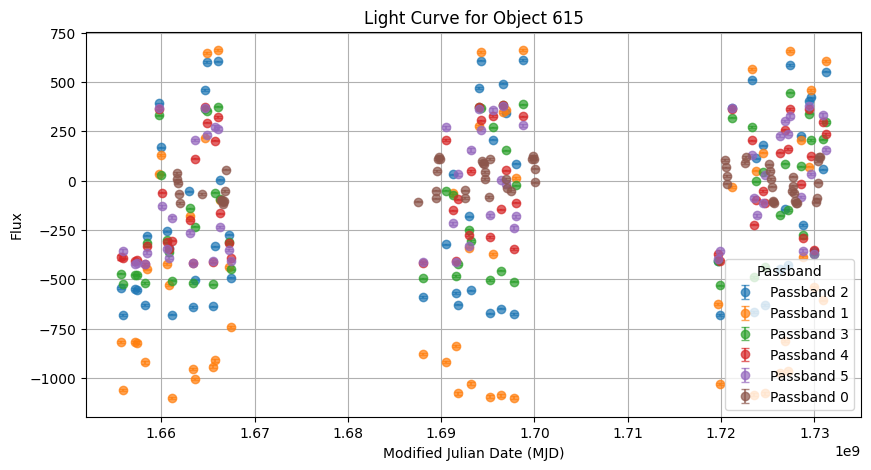

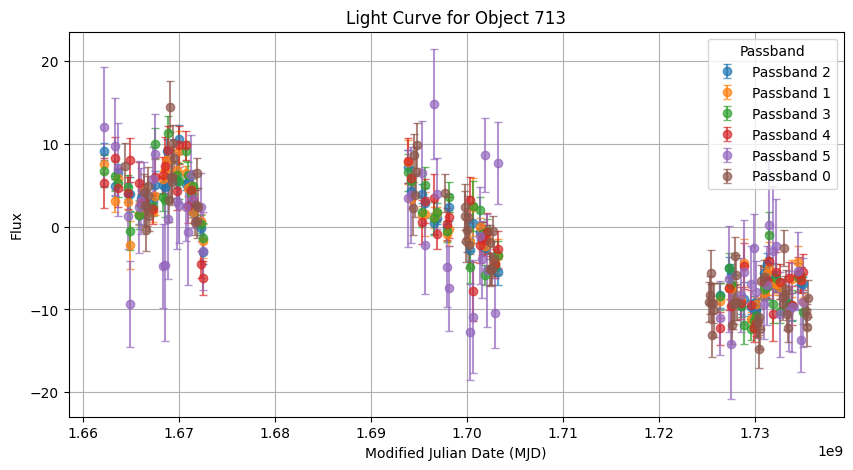

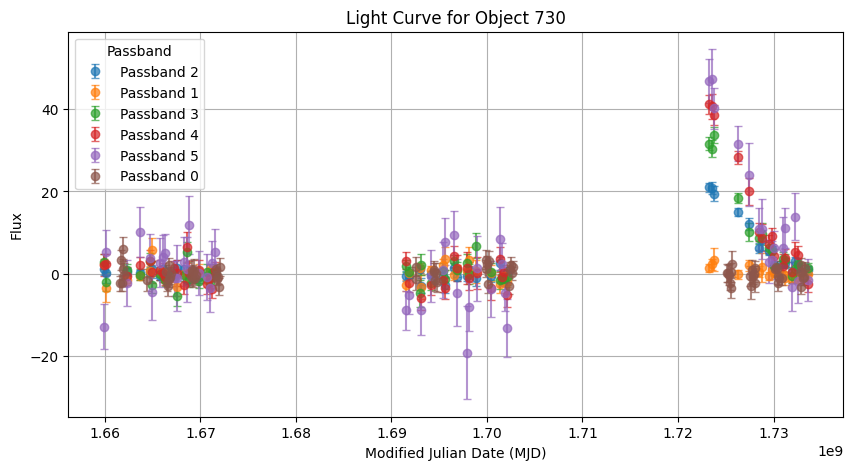

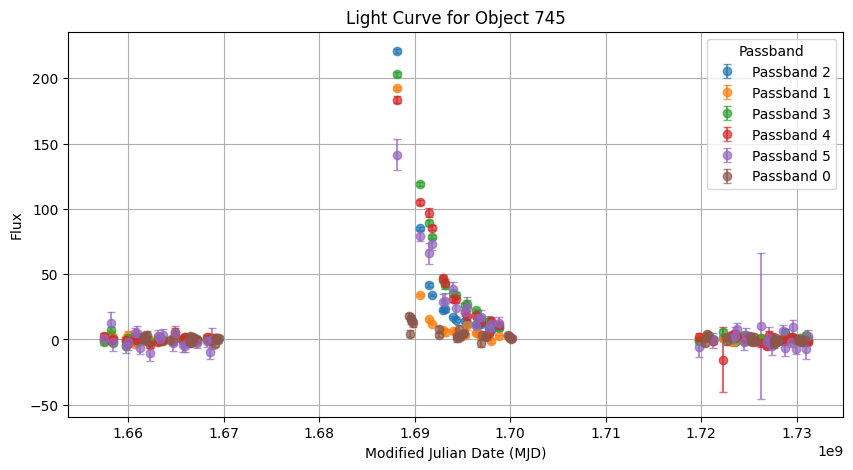

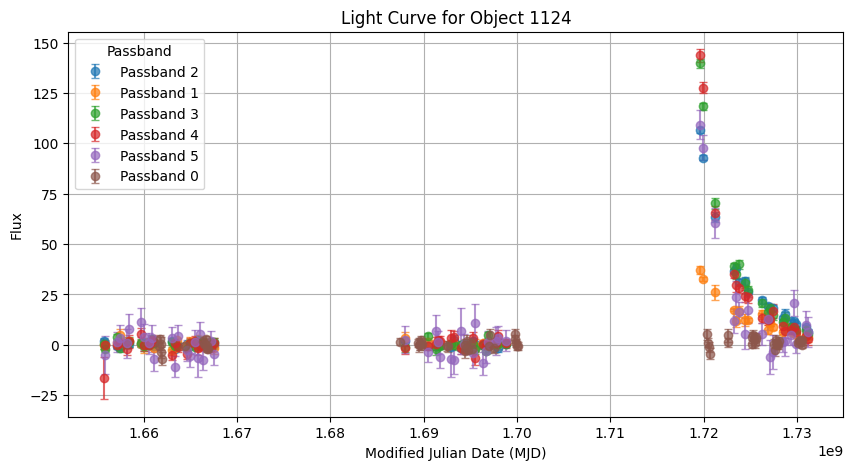

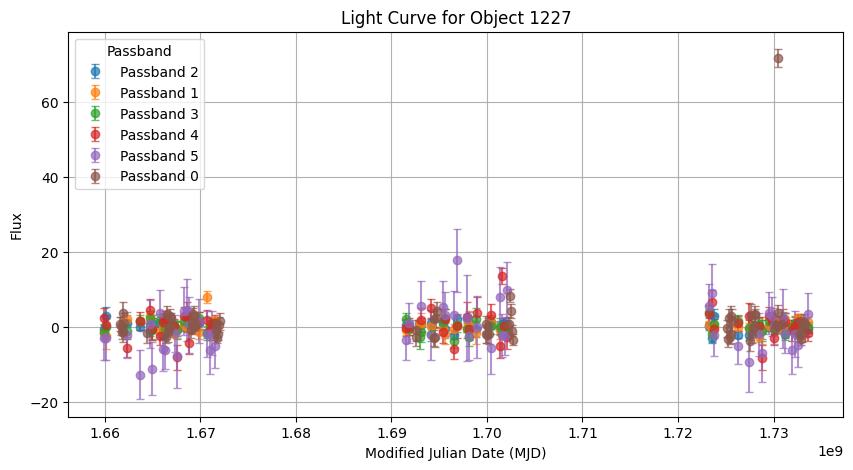

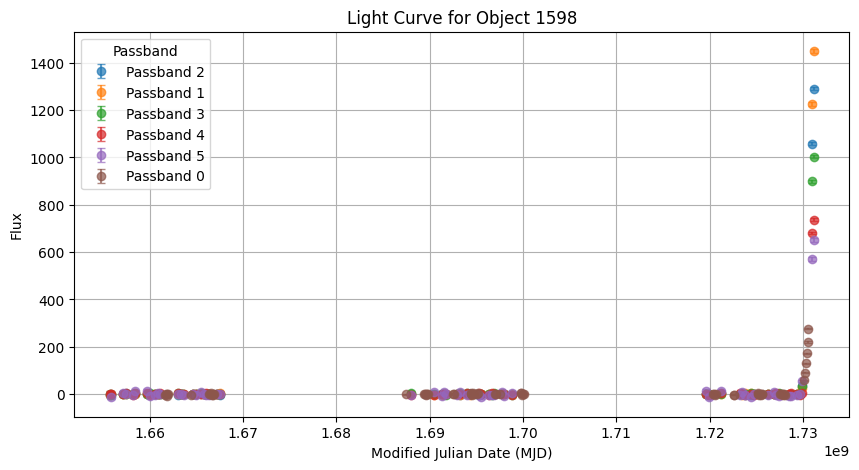

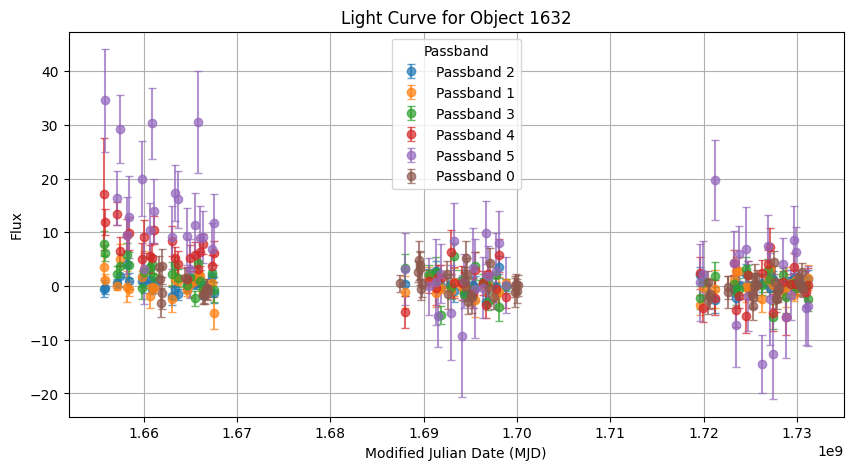

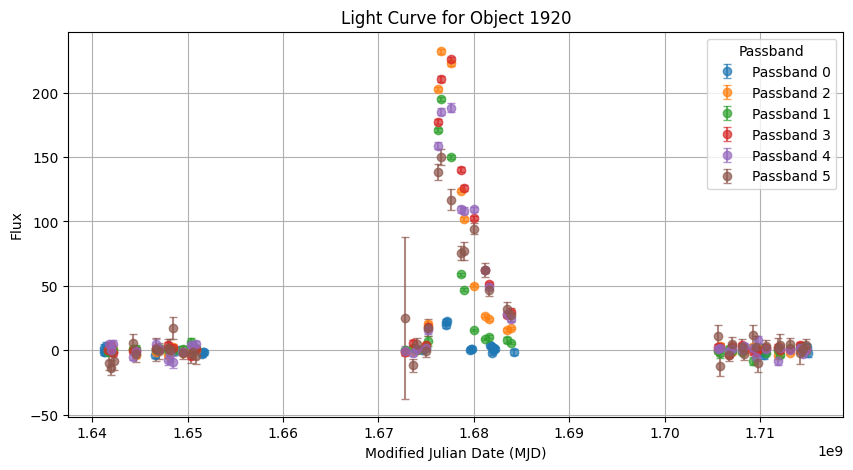

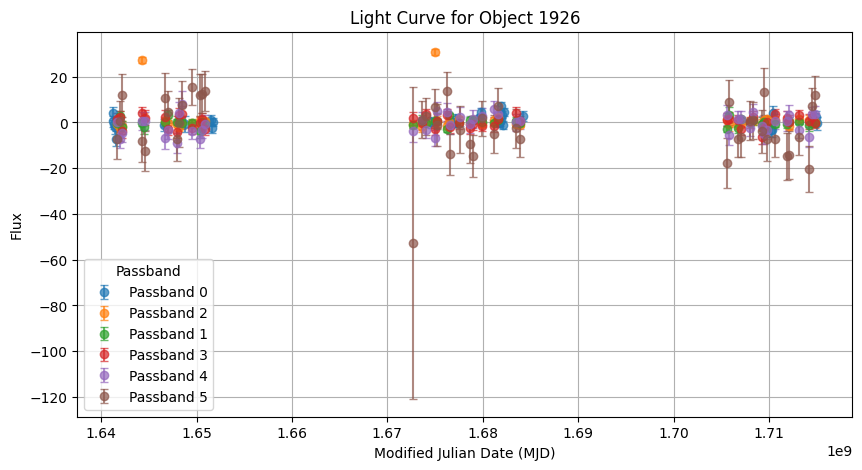

In [23]:
palette = sns.color_palette("tab10", n_colors=lcvs['passband'].nunique())

plt.figure(figsize=(12, 8))

for obj_id in sample_objects:
    obj_data = lcvs[lcvs['object_id'] == obj_id]

    plt.figure(figsize=(10, 5))

    for pb in obj_data['passband'].unique():
        pb_data = obj_data[obj_data['passband'] == pb]

        plt.errorbar(pb_data['mjd'], pb_data['flux'], yerr=pb_data['flux_err'],
                     fmt='o', label=f'Passband {pb}', alpha=0.7, capsize=3)

    plt.title(f'Light Curve for Object {obj_id}')
    plt.xlabel('Modified Julian Date (MJD)')
    plt.ylabel('Flux')
    plt.legend(title='Passband')
    plt.grid(True)
    plt.show()



Figure 1: These are light curves for the first 10 observed phenomena in the dataset. The color of the points correspond to the specific passband observed at the given point in time. Error bars are also shown for each point. Worth mentioning is the two distinct gaps present in every plot, which likely are caused by the cadence of the telescope (we know it takes long gaps to look at other patches of sky).  

Plot explicitly object 84716

<Figure size 1200x800 with 0 Axes>

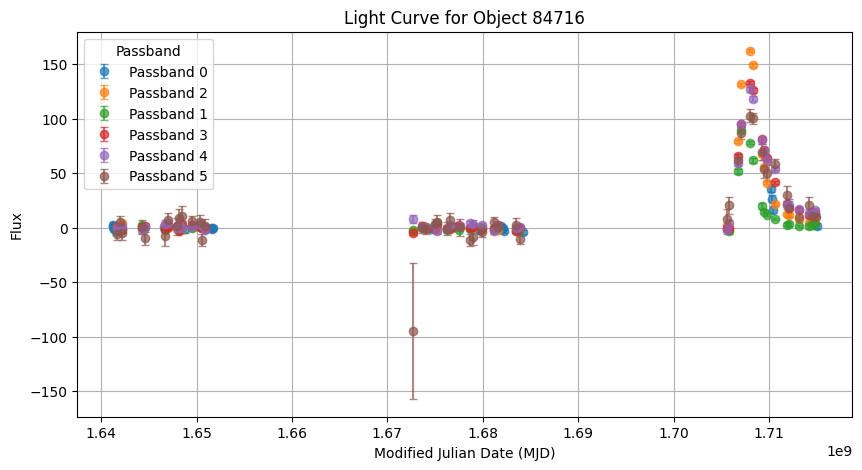

In [24]:
plt.figure(figsize=(12, 8))

obj_id=84716
obj_data = lcvs[lcvs['object_id'] == obj_id]

plt.figure(figsize=(10, 5))

for pb in obj_data['passband'].unique():
    pb_data = obj_data[obj_data['passband'] == pb]

    plt.errorbar(pb_data['mjd'], pb_data['flux'], yerr=pb_data['flux_err'],
                     fmt='o', label=f'Passband {pb}', alpha=0.7, capsize=3)

plt.title(f'Light Curve for Object {obj_id}')
plt.xlabel('Modified Julian Date (MJD)')
plt.ylabel('Flux')
plt.legend(title='Passband')
plt.grid(True)
plt.show()

Figure 2: This is the plot of object 84716. We can see that it maintains the same flux over most of the time. The object gets noticeable brighter towards the rightmost end of the plot.



# TASK III: Extract features

Feature extraction refers to the extraction of statistical features of the datapoints or the generation of low dimensional representations of the data points that can then be passed to a classifier/regression

Extract at least 4 features including at least 1 feature from all three category below

The code that won the callenge did a number of smart things, of course. It was a feature based classification scheme, which included Gaussian Processes in the preprocessing. The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py

Examples of features you can extract:

- **from the original lightcurve**:
    - mean,
    - standard deviation,
    - skewness,
    - kurthosis,
    - minimum
    - maximmum,
    - error on the minimum and
    - error on the maximum,
- **from the standardized lightcurve**:
    - median
    - slope of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter


- **from the metadata file**:
    - decl; this is one of the positions in the sky variables: important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    
The feature in the metadata files are the hardest ones to decide on because they require domain knowledge.
Most of the other features in the metadata are unknown for test objects (only known for the training set)


Extract at least 4 features including 1 features from all three category above: original lcv, standardized lcv, metadata. Justify each feature. Coming up with different features than the ones I suggested is very welcome! Remember that if the features are extracted from the time series there will be 4 features for each passbands.

Note: we are working with bigg-ish data!
First off: every new piece should be developed on a subset of the dataset, then run on all the data only when ready.
Still, if you try achieve goals by implementing for loops you are not going to be able to run the notebook for the whole data, or even only 1 batch of the full datase. A good solution is to use the groupby() method in pandas. I used groupby everywhere. Also it may be wise to write out intermediate outputs, so you do not have to loose work if your kernel dies or something similar.


describe each feature you plan to extract. Briefly indicate why you think it is a valuable feature and what data type is it (e.g. continuous, binary, categorical, if continuous does it have a max or min value or is it unbound?)

        

### extract some features from the raw lightcurve -


higher order moments of the distribution can be obtained with the scipy.stats.moment() function which can be applied to a grouby() object
note that this way you can apply a function that takes only one argument, the argument over which groupby iterates (the flux here). But moments take 2: the value and the moment Create a function call

In [25]:
#example
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()
means

flux
object_id passband             
615       0           -3.254554
          1         -385.699911
          2         -134.146566
          3         -121.103501
          4          -55.954592
...                         ...
130779836 1          725.169852
          2         2690.360415
          3          755.993902
          4         3489.185336
          5         4151.358875

[47088 rows x 1 columns]

In [26]:
#Extract other features
# Ensure index is reset without duplicating existing columns
lcvs = lcvs.reset_index(drop=True)

# Extracting features using groupby
lcvs_features = lcvs.groupby(['object_id', 'passband']).agg(
    mean_flux=('flux', 'mean'),
    std_flux=('flux', 'std'),

).reset_index()

# Display the extracted features
lcvs_features.head(10)


,object_id,passband,mean_flux,std_flux
0,615,0,-3.254554,83.944735
1,615,1,-385.699911,601.787302
2,615,2,-134.146566,455.121346
3,615,3,-121.103501,335.425053
4,615,4,-55.954592,291.803449
5,615,5,-47.449847,294.779522
6,713,0,-2.720398,7.113509
7,713,1,-1.019804,5.712334
8,713,2,-0.794238,5.770738
9,713,3,-0.986966,6.450413


In [27]:
#example
from scipy import stats
def m2(x):
    return stats.moment(x, moment = 2)


Even with the same standard deviation two distribution can be very different.
Look at the this article for a great demonstation of that! https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story

I extracted  the max and min, but also their uncertainties because outlier points may be measurement issues, in which case the uncertainty may be large : see the plot you made for 84716!

If a distribution has spikes the standard deviation will be larger even if the other datapoints are exactly the same. Save the mean and the max of both original distribution and the standardized one (standardized = mean subtracted and divided by the standard deviation).


Standardize the lcvs and extract some features from the raw lightcurve -


In [28]:
# prompt: Take the lcvs dataset and standardize the flux. Make this as a new dataframe. Also standardize the flux errors too. Use the preprocessing,scale function

from sklearn import preprocessing

# Assuming 'lcvs' DataFrame is already loaded and processed as in the previous code.

# Standardize flux
lcvs['flux_scaled'] = lcvs.groupby(['object_id', 'passband'])['flux'].transform(preprocessing.scale)

# Standardize flux errors
lcvs['flux_err_scaled'] = lcvs.groupby(['object_id', 'passband'])['flux_err'].transform(lambda x: preprocessing.scale(x))

# Create a new DataFrame with the standardized features
lcvs_scaled = lcvs[['object_id', 'mjd', 'passband', 'flux_scaled', 'flux_err_scaled']].copy()


You can do it use  the preprocessing.scale function and groupby, which group by object and band. It does its job, but it is slow

In [29]:
mean_norm = lcvs_scaled.groupby(['object_id', 'passband'])[['flux_scaled']].mean()
std_norm = lcvs_scaled.groupby(['object_id', 'passband'])[['flux_scaled']].std()

'''
print("Mean:", mean_norm)
print("Standard Deviation:", std_norm)
'''
mean_norm.head()
std_norm.head()
lcvs_scaled.head()

,object_id,mjd,passband,flux_scaled,flux_err_scaled
0,615,1.655720e+09,2,-0.910198,0.422316
1,615,1.655720e+09,1,-0.722010,0.452984
2,615,1.655721e+09,3,-1.053414,1.338867
3,615,1.655722e+09,4,-1.151251,7.037395
4,615,1.655891e+09,2,-1.213953,1.150246


Note: the median of the standardizeed distribution would convey the location of the "center of mass" of the data with respect to the mean


parametric features: extract some features that come from simple models of the lightcurve, e.g. line fits



In [ ]:
?sm.add_constant

In [30]:
# prompt: parametric features: extract some features that come from simple models of the lightcurve, e.g. line fits

import pandas as pd
# Group data by object and passband
grouped = lcvs_scaled.groupby(['object_id', 'passband'])
grouped2 = lcvs.groupby(['object_id', 'passband'])
# Function to fit a line and extract features
def fit_line(group):
  '''
  Fits a line to the light curve and extracts the slope.
  Inputs:
    group: the id and passband group
  Outputs:
    slope: the slope of the line fit
  '''
  x = group['mjd'].values
  y = group['flux_scaled'].values
  X = sm.add_constant(x)
  model = sm.OLS(y, X).fit()
  return pd.Series({
      'slope': model.params[1],

    })

# Apply the line fitting function to each group
line_fits = grouped.apply(fit_line)
#lf2 = grouped2.apply(fit_line)
# Reset the index to make 'object_id' and 'passband' regular columns
line_fits = line_fits.reset_index()
#lf2 = lf2.reset_index()

# Now lcvs_scaled contains the slope, intercept and R-squared of the linear fit for each object and passband.
line_fits.head(20)
#lf2.head()

<ipython-input-30-09cb33264753>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  line_fits = grouped.apply(fit_line)


,object_id,passband,slope
0,615,0,6.110065e-09
1,615,1,6.524368e-09
2,615,2,8.751262e-09
3,615,3,1.059614e-08
4,615,4,1.210627e-08
5,615,5,1.171332e-08
6,713,0,-3.333159e-08
7,713,1,-3.268803e-08
8,713,2,-3.311729e-08
9,713,3,-3.209327e-08


the goodness of fit for these models is also a potential feature

#Extracting feature from the metadata

In [31]:
lmeta.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [32]:
declCol = lmeta["decl"]
declCol.head()

#this represents the position in the sky.
#Can help determine if the phenomena is a galactic or extragalactic object

,decl
0,-61.943836
1,-27.784405
2,-6.579593
3,-45.586655
4,-63.823658


Data Organization: you can put all your features in a dataframe using merge at each step merging each new feature with the olde ones


In [33]:
#example
features = lcvs_features.merge(line_fits, left_index=True, right_index=True)
features = features.merge(declCol, left_index=True, right_index=True)
features.head()

,object_id_x,passband_x,mean_flux,std_flux,object_id_y,passband_y,slope,decl
0,615,0,-3.254554,83.944735,615,0,6.110065e-09,-61.943836
1,615,1,-385.699911,601.787302,615,1,6.524368e-09,-27.784405
2,615,2,-134.146566,455.121346,615,2,8.751262e-09,-6.579593
3,615,3,-121.103501,335.425053,615,3,1.059614e-08,-45.586655
4,615,4,-55.954592,291.803449,615,4,1.210627e-08,-63.823658


In [34]:

# Drop the specified columns
features = features.drop(columns=['object_id_y', 'passband_y'], errors='ignore')
features = features.rename(columns={'object_id_x': 'object_id', 'passband_x': 'passband'})
# Display the updated DataFrame (optional)
features.head()


,object_id,passband,mean_flux,std_flux,slope,decl
0,615,0,-3.254554,83.944735,6.110065e-09,-61.943836
1,615,1,-385.699911,601.787302,6.524368e-09,-27.784405
2,615,2,-134.146566,455.121346,8.751262e-09,-6.579593
3,615,3,-121.103501,335.425053,1.059614e-08,-45.586655
4,615,4,-55.954592,291.803449,1.210627e-08,-63.823658


NOTE: when you merge the metadata features you are going to have to do some gymnastic with the indices: this is because the data has 2 indices columns: the object id and the bandpass id, while the metadata has only 1 index: the object id.

You can use the function unstuck - here is an example line of code of what worked for me **but** it kind of depends on how you organized your dataframe so this is not guaranteed to work!

In [35]:
features.groupby(["object_id", "passband"]).head()

,object_id,passband,mean_flux,std_flux,slope,decl
0,615,0,-3.254554,83.944735,6.110065e-09,-61.943836
1,615,1,-385.699911,601.787302,6.524368e-09,-27.784405
2,615,2,-134.146566,455.121346,8.751262e-09,-6.579593
3,615,3,-121.103501,335.425053,1.059614e-08,-45.586655
4,615,4,-55.954592,291.803449,1.210627e-08,-63.823658
...,...,...,...,...,...,...
7843,213773,1,6.043111,19.564988,-1.586248e-08,-14.940303
7844,213773,2,11.479484,30.400309,-1.929501e-08,-62.696659
7845,213773,3,14.859417,32.053141,-2.227362e-08,-55.682144
7846,213773,4,14.099035,29.688482,-2.354129e-08,-35.501846


In [36]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])
allfeatures.shape

(1308, 30)

In [37]:
#EXAMPLE OF A POTENTIAL DATAFRAME OUTPUT
allfeatures.head()

passband      0                                                   1  \
          index mean_flux   std_flux         slope       decl index   
object_id                                                             
615         0.0 -3.254554  83.944735  6.110065e-09 -61.943836   1.0   
713         6.0 -2.720398   7.113509 -3.333159e-08 -64.760857   7.0   
730        12.0 -0.048080   1.828872 -1.410225e-09 -44.201530  13.0   
745        18.0  1.797523   4.374445 -8.154511e-09   1.641510  19.0   
1124       24.0  0.660948   2.360084  1.440216e-08 -45.783966  25.0   

passband                                                    ...     4  \
            mean_flux    std_flux         slope       decl  ... index   
object_id                                                   ...         
615       -385.699911  601.787302  6.524368e-09 -27.784405  ...   4.0   
713         -1.019804    5.712334 -3.268803e-08 -63.072620  ...  10.0   
730          0.141057    1.807229  3.942850e-09 -46.768478  ...  16.0   
745          5.717394   25.964659 -1.076001e-09 -63.636005  ...  22.0   
1124         4.634637    8.107525  2.177296e-08   3.284369  ...  28.0   

passband                                                      5             \
           mean_flux    std_flux         slope       decl index  mean_flux   
object_id                                                                    
615       -55.954592  291.803449  1.210627e-08 -63.823658   5.0 -47.449847   
713        -0.900262    6.406989 -3.131527e-08 -46.375080  11.0  -1.794175   
730         4.308728   10.710344  1.727045e-08 -62.696659  17.0   4.539396   
745        13.134436   33.069053 -1.260246e-09 -46.375080  23.0  10.746138   
1124        9.906102   26.865913  1.568889e-08 -63.636005  29.0   6.896742   

passband                                        
             std_flux         slope       decl  
object_id                                       
615        294.779522  1.171332e-08  -5.379379  
713          7.094073 -2.310524e-08 -62.320400  
730         13.332758  1.471506e-08 -63.072620  
745         26.060130  3.092837e-11 -45.191612  
1124        21.434627  1.296715e-08  -5.979157  

[5 rows x 30 columns]

what is the shape of your final feature space?

In [38]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1]))

My feature space is 30 features (columns)


Now make histograms for allfeatures to show their distributions

<ipython-input-39-c1e4e36bac4f>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  pl.figure()


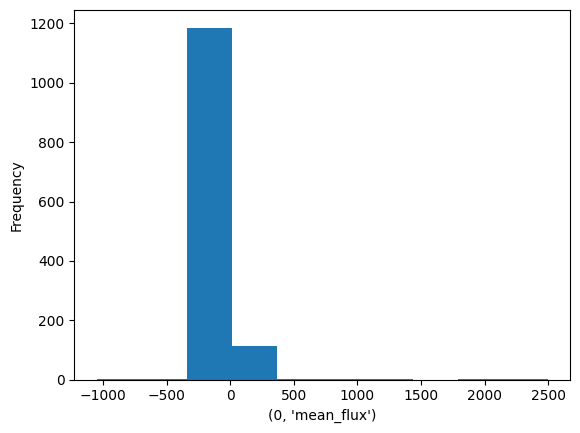

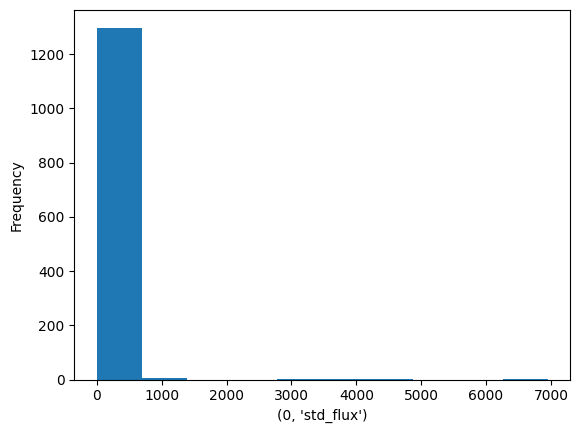

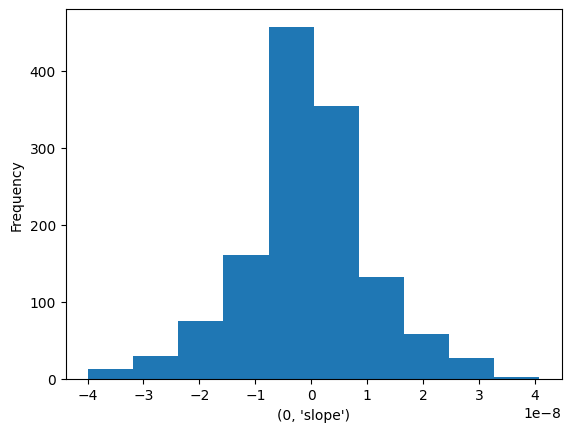

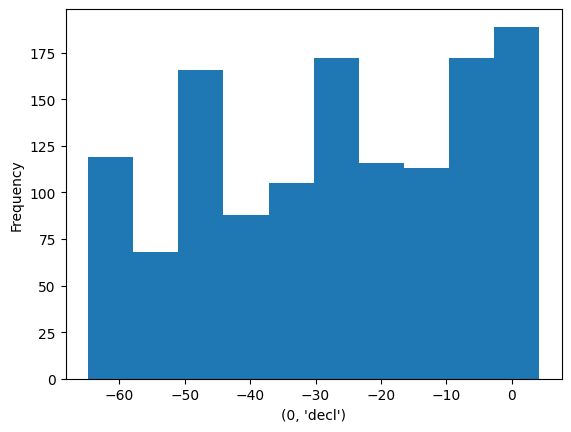

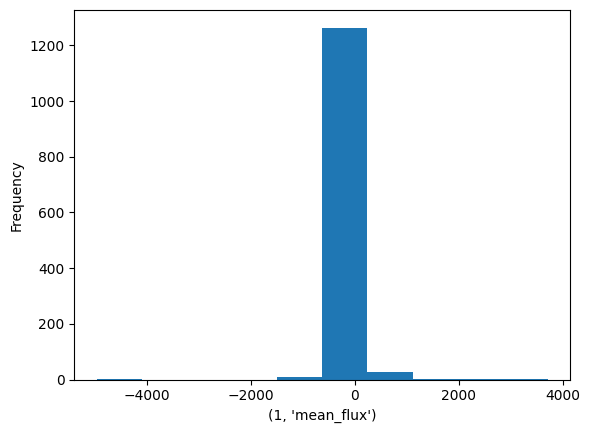

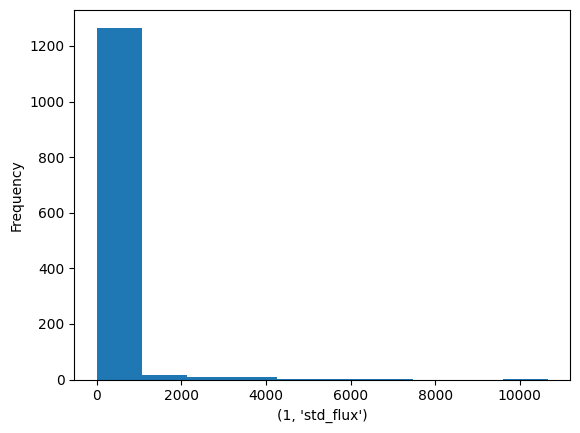

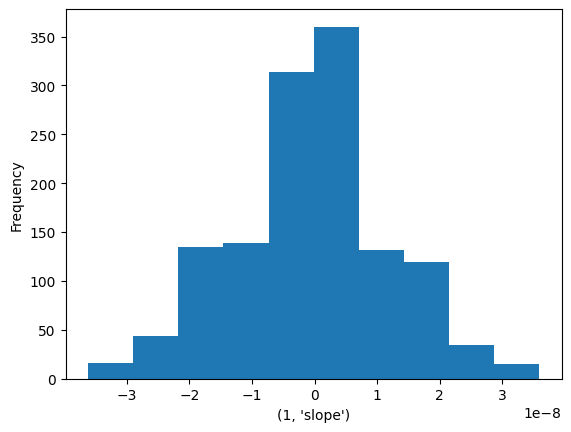

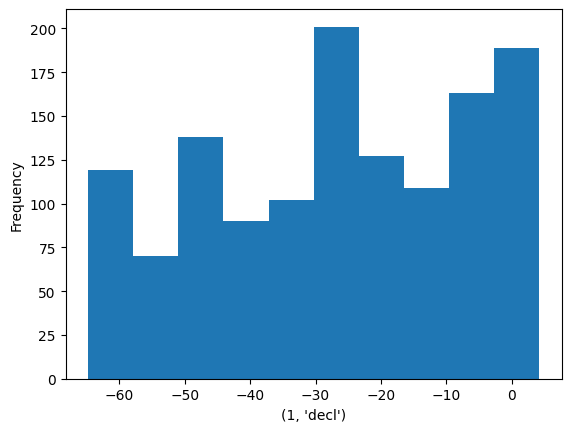

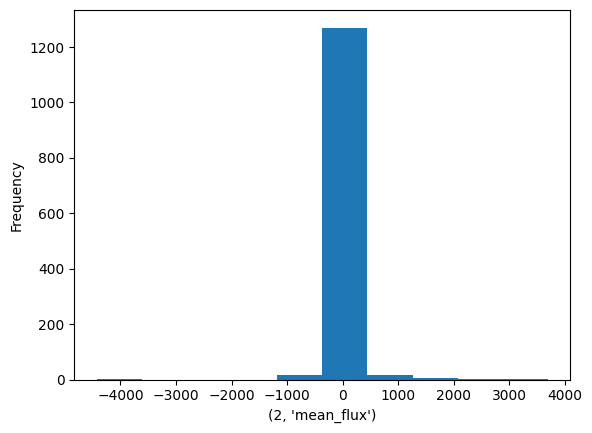

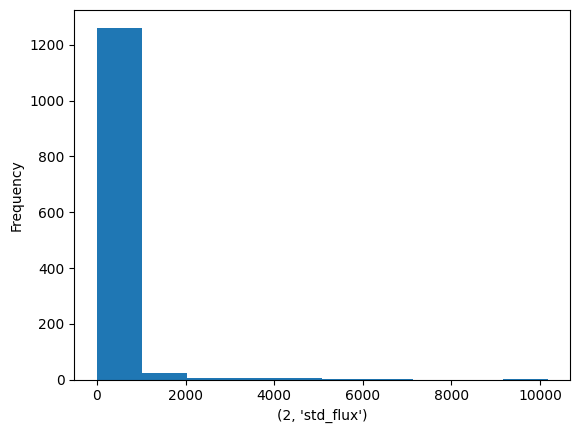

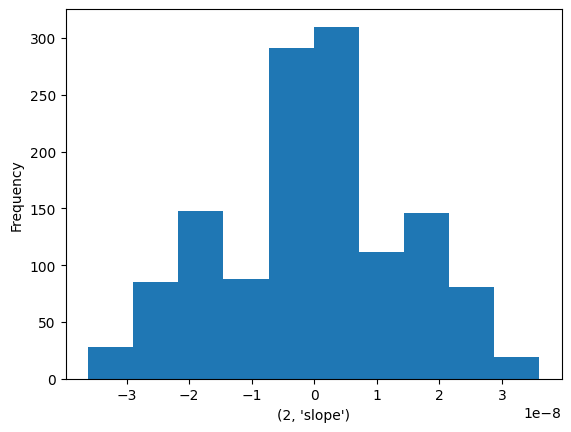

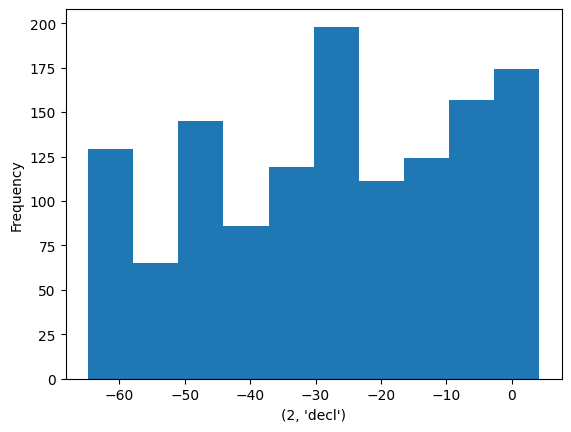

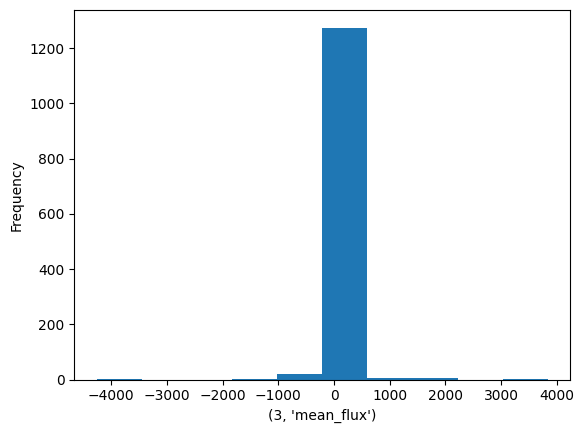

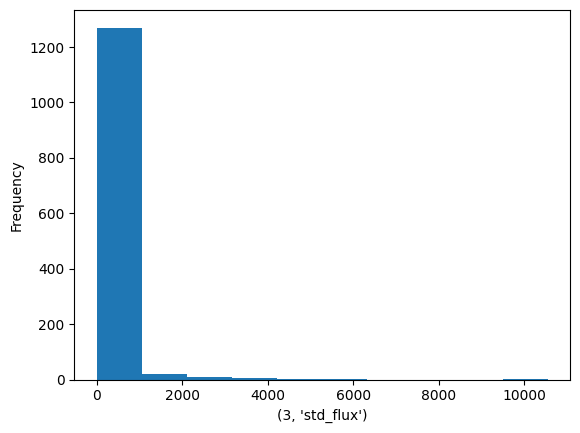

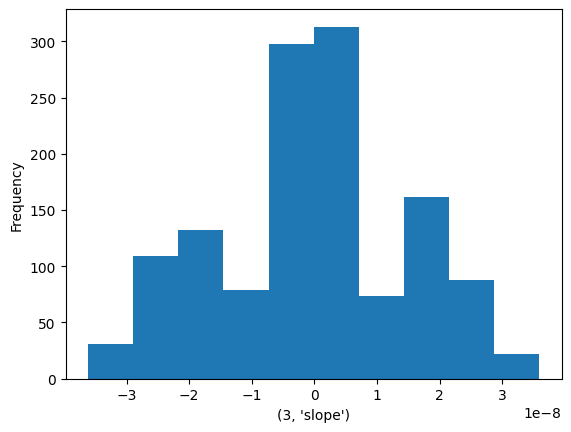

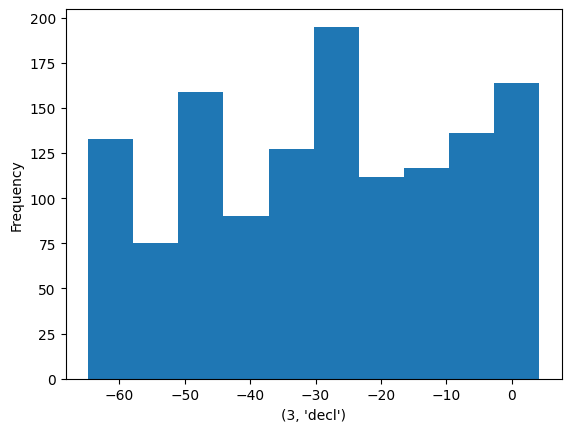

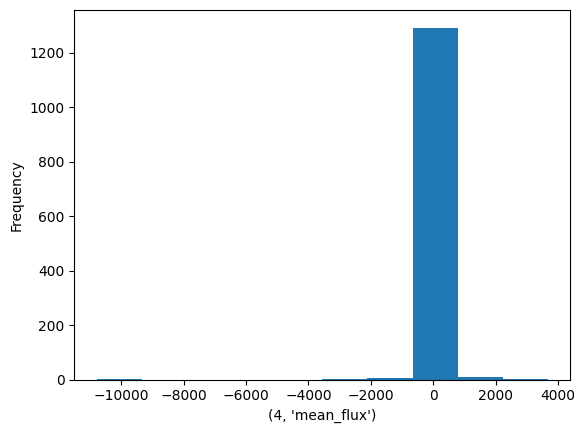

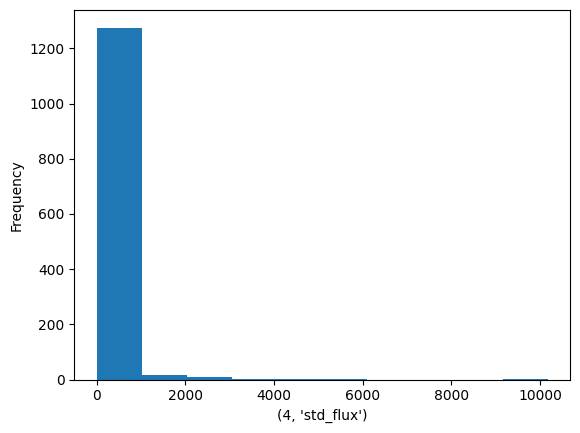

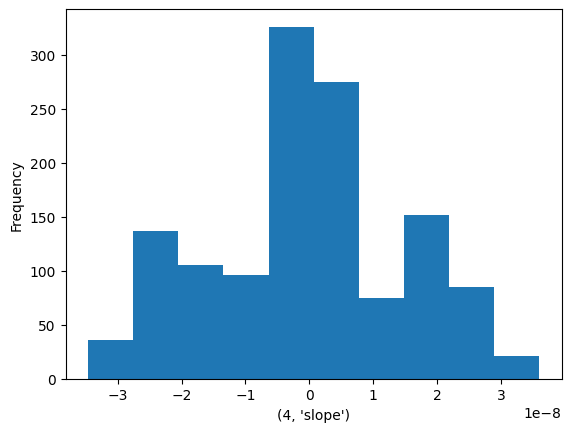

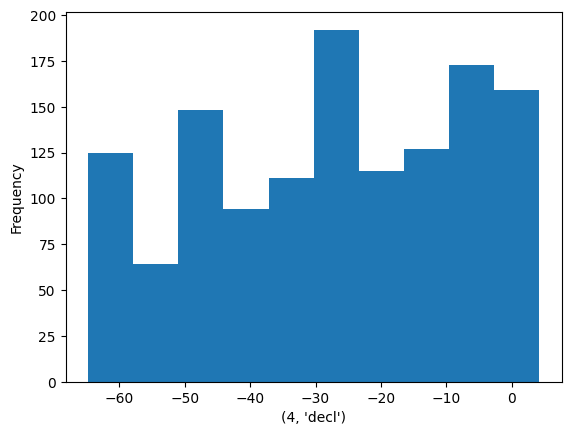

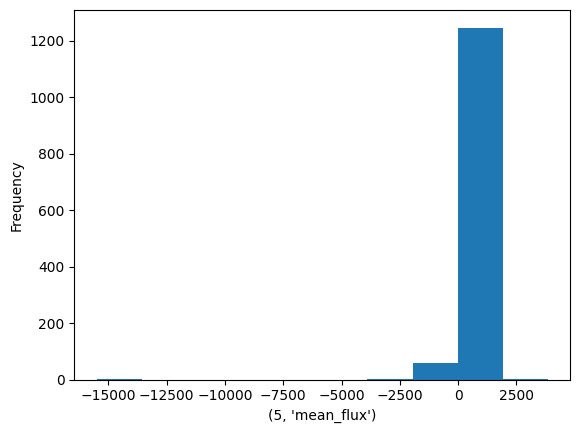

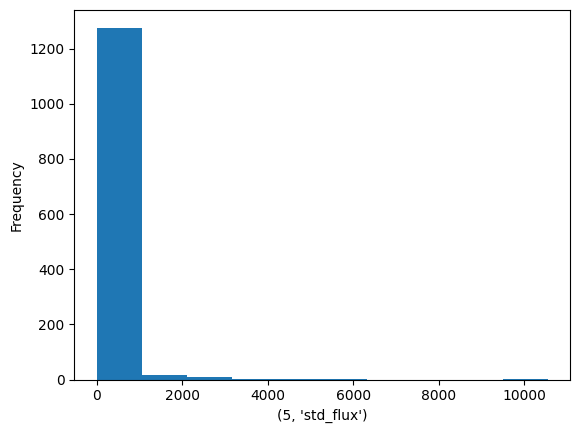

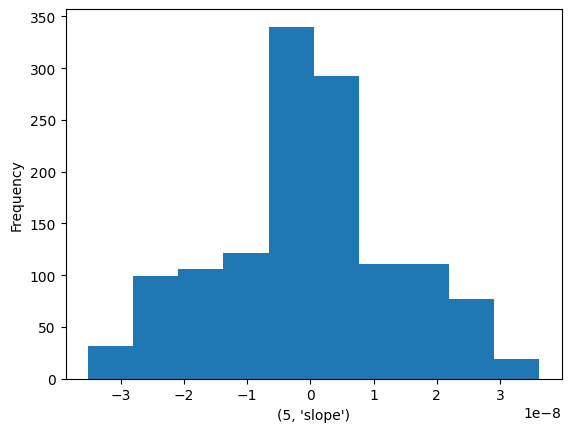

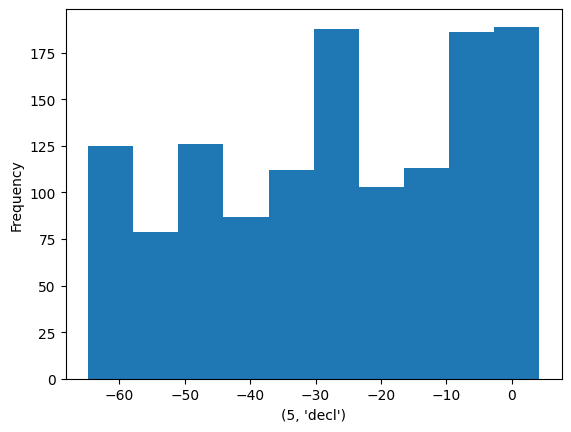

In [39]:
for i in allfeatures.columns:

  if i[1] == "index" or i[0] == "index":
    continue

  pl.figure()
  pl.hist(allfeatures[i])
  pl.xlabel(i)
  pl.ylabel('Frequency')


# TASK III : Gaussian Processes

Take the time series and fit them with GPs.
- use the george package goerge (see class demo https://github.com/fedhere/MLTSA_FBianco/blob/main/CodeExamples/GP_examples.ipynb)

- make sure you use the standardized time series : before you fit the GP to it each time series shoud be made to be mean 0 and standard deviation 1 (note - mean across all time stamps! not across all lightcurves). YOu can just do it by hand as lc /= lc.mean() or you can use `sklearn.preprocessing.StandardScaler`

- make sure you process the uncertainty as well as the data in the standardization! (divide by the same constant the lighcruve fluxes and its uncertaities)

- choose an appropriate kernel (e.g. the composite one we use in class that enables periodicity as well as stockastic variations)

- take a subset of the time series, ~10, making sure that they are of different types: the type is mapped to the metadata `target` variable

- fit the GP kernerl to each time series band by band

- collect the best fit parameters and describe their variance (across the 10 time series) `gp.get_parameter_vector()` - can all the time series be fit with the same kernel parameters? how would you initialize the fit for the whole ensamble?



In [40]:
!pip install george

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 kB 5.1 MB/s eta 0:00:00


In [41]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern, ExpSineSquared
from sklearn.preprocessing import StandardScaler
from george import kernels
import george

In [42]:
?StandardScaler

In [43]:
# prompt: use Standard Scaler to standardize  the flux and flux error lcvs_scaled across all time stamps

# Use StandardScaler to standardize 'flux_scaled' and 'flux_err_scaled' across all timestamps.

scaler = StandardScaler()

lcvs_scaled[['flux_scaled', 'flux_err_scaled']] = scaler.fit_transform(lcvs_scaled[['flux_scaled', 'flux_err_scaled']])
lcvs_scaled.head()


,object_id,mjd,passband,flux_scaled,flux_err_scaled
0,615,1.655720e+09,2,-0.910198,0.422316
1,615,1.655720e+09,1,-0.722010,0.452984
2,615,1.655721e+09,3,-1.053414,1.338867
3,615,1.655722e+09,4,-1.151251,7.037395
4,615,1.655891e+09,2,-1.213953,1.150246


In [44]:
#Preprocessing the data for mean 0 and sd 1
#lcvs_scaled = lcvs_scaled.groupby(['object_id', 'passband']).apply(lambda x: (x - x.mean()) / x.std())
lcvs_scaled.head()

,object_id,mjd,passband,flux_scaled,flux_err_scaled
0,615,1.655720e+09,2,-0.910198,0.422316
1,615,1.655720e+09,1,-0.722010,0.452984
2,615,1.655721e+09,3,-1.053414,1.338867
3,615,1.655722e+09,4,-1.151251,7.037395
4,615,1.655891e+09,2,-1.213953,1.150246


In [45]:
lcvs_scaled["flux_scaled"].mean()
lcvs_scaled["flux_scaled"].std()

lcvs_scaled["flux_err_scaled"].mean()
#lcvs_scaled["flux_err_scaled"].std()

1.163242879135709e-18

take a subset of the time series, ~10, making sure that they are of different types: the type is mapped to the metadata target variable

fit the GP kernerl to each time series band by band

collect the best fit parameters and describe their variance (across the 10 time series) gp.get_parameter_vector() - can all the time series be fit with the same kernel parameters? how would you initialize the fit for the whole ensamble?

In [46]:
# prompt: I need a time prediction space to use for fitting gaussian process to my data

import numpy as np
# Create a time prediction space
min_time = lcvs_scaled['mjd'].min()
max_time = lcvs_scaled['mjd'].max()
t_pred = np.linspace(min_time, max_time, 500) # Adjust the number of points as needed
t_pred

array([1.64099816e+09, 1.64118764e+09, 1.64137712e+09, 1.64156660e+09,
       1.64175608e+09, 1.64194556e+09, 1.64213504e+09, 1.64232452e+09,
       1.64251400e+09, 1.64270347e+09, 1.64289295e+09, 1.64308243e+09,
       1.64327191e+09, 1.64346139e+09, 1.64365087e+09, 1.64384035e+09,
       1.64402983e+09, 1.64421931e+09, 1.64440878e+09, 1.64459826e+09,
       1.64478774e+09, 1.64497722e+09, 1.64516670e+09, 1.64535618e+09,
       1.64554566e+09, 1.64573514e+09, 1.64592462e+09, 1.64611410e+09,
       1.64630357e+09, 1.64649305e+09, 1.64668253e+09, 1.64687201e+09,
       1.64706149e+09, 1.64725097e+09, 1.64744045e+09, 1.64762993e+09,
       1.64781941e+09, 1.64800888e+09, 1.64819836e+09, 1.64838784e+09,
       1.64857732e+09, 1.64876680e+09, 1.64895628e+09, 1.64914576e+09,
       1.64933524e+09, 1.64952472e+09, 1.64971420e+09, 1.64990367e+09,
       1.65009315e+09, 1.65028263e+09, 1.65047211e+09, 1.65066159e+09,
       1.65085107e+09, 1.65104055e+09, 1.65123003e+09, 1.65141951e+09,
      

In [47]:

# Assuming lcvs_scaled and metadata DataFrames are already loaded and processed.

# Select 10 unique object IDs with different target values
unique_targets = metadata['target'].unique()[:10]  # Select the first 10 unique targets
selected_object_ids = []
for target in unique_targets:
    object_id = metadata[metadata['target'] == target]['object_id'].iloc[0]
    selected_object_ids.append(object_id)

# Filter the light curves data for selected objects
selected_lcvs = lcvs_scaled[lcvs_scaled['object_id'].isin(selected_object_ids)]

# Fit a GP to each time series (band by band)
params = pd.DataFrame(columns=['obj_id', 'param1', 'param2', 'param3'])
for object_id in selected_object_ids:
    for passband in selected_lcvs["passband"].unique():
        # Get data for the specific object and passband
        subset = selected_lcvs[(selected_lcvs['object_id'] == object_id) & (selected_lcvs['passband'] == passband)]
        x = subset['mjd'].values
        y = subset['flux_scaled'].values
        yerr = subset['flux_err_scaled'].values

        # Define the kernel
        kernel = np.var(y) * kernels.Product(kernels.ExpSquaredKernel(0.5),
                                     kernels.CosineKernel(1))



        # Initialize the GP
        gp = george.GP(kernel)

        # Try to fit the GP (error handling)


        #try:
        gp.compute(x, yerr)
        gp.predict(y, t_pred, return_var=True)
        params = pd.concat([params, pd.DataFrame([[object_id, *gp.get_parameter_vector()]], columns=['obj_id','param1', 'param2', 'param3'])])
        '''
        except Exception as e:
            print(f"Object {object_id}, Passband {passband}: Error fitting GP: {e}")
            continue
        '''
            #gp.optimize(x,y)


params

<ipython-input-47-5d92cb2d8c26>:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  params = pd.concat([params, pd.DataFrame([[object_id, *gp.get_parameter_vector()]], columns=['obj_id','param1', 'param2', 'param3'])])


,obj_id,param1,param2,param3
0,615,-2.220446e-16,-0.693147,1.0
0,615,2.220446e-16,-0.693147,1.0
0,615,2.220446e-16,-0.693147,1.0
0,615,0.000000e+00,-0.693147,1.0
0,615,-1.110223e-16,-0.693147,1.0
0,615,2.220446e-16,-0.693147,1.0
0,713,0.000000e+00,-0.693147,1.0
0,713,2.220446e-16,-0.693147,1.0
0,713,0.000000e+00,-0.693147,1.0
0,713,-3.330669e-16,-0.693147,1.0


collect the best fit parameters and describe their variance (across the 10 time series) gp.get_parameter_vector() - can all the time series be fit with the same kernel parameters? how would you initialize the fit for the whole ensamble?

In [48]:
params.shape

(60, 4)

In [49]:
# prompt: get the variance of both parameters for each object

# Calculate variance of parameters for each object
param_variance = params.groupby('obj_id').var()
param_variance


,param1,param2,param3
obj_id,,,
615,3.821045e-32,0.0,0.0
713,3.821045e-32,0.0,0.0
730,2.054325e-33,0.0,0.0
745,1.314768e-32,0.0,0.0
1227,3.821045e-32,0.0,0.0
2677,4.149737e-32,0.0,0.0
2922,4.149737e-32,0.0,0.0
3423,3.821045e-32,0.0,0.0
3910,1.314768e-32,0.0,0.0


The variance appears to be near zero across all parameters. This means that the parameter values are not deviating too far from the mean. Thus, we could take the mean of each parameter (keeping the constant value for the constant ones) and use that to initialize the fit for the whole dataset.

# CHALLENGE (Extra Credit): fit the 2D time series:
- create a 2D array for each of the ~10 time series you used earlier: 1 dimension is time the other is wavelength (the bandpass)
- fit a 2D kernel to the time series.
- show the fits with their uncertainties marginalized along one feature at a time: the fit along the time axis for all 6 bands and the fit along the wavelength axis for a subset of the datapoints.
- (try and make a surface plot  that conveys the relevant info effectively, I find it difficult)